# 📌 Intro.

- Exploration 학습 노드에서 MLOps 에 대해 학습하고 구현하는 방법을 학습했습니다.
- 특히 TFX(TensorFlow Extended)와 Data Cenctric AI, KerasTuner를 통해 모델을 구현하고 이를 TFServing과 TFLite로 일반적인 모델 배포와 경량화된 모델 배포를 하는 방법을 학습했습니다.
- 이 내용들을 기반으로 CIFAR10 데이터셋을 통해 다중 클래스 분류를 하는 딥러닝 모델을 만들고 배포합니다.
- 이번 프로젝트의 평가 루브릭은 아래와 같습니다.

<!DOCTYPE html>
<html>
<head>
</head>
<body>
    <table>
        <tr>
            <th style="text-align: left;">평가문항</th>
            <th style="text-align: left;">상세기준</th>
        </tr>
        <tr>
            <td style="text-align: left;">1. 그림에 맞게 딥러닝 모델을 잘 설계하였는가?</td>
            <td style="text-align: left;">그림에 맞게 딥러닝 모델을 설계했다.</td>
        </tr>
        <tr>
            <td style="text-align: left;">2. 잘못 들어간 test label들을 수정하였는가?</td>
            <td style="text-align: left;">틀린 Label 22개를 전부 시각화했으며 Label 또한 수정했다.</td>
        </tr>
        <tr>
            <td style="text-align: left;">3. KerasTuner로 하이퍼파라미터 튜닝을 진행하였는가?</td>
            <td style="text-align: left;">KerasTuner를 정상작동하였고 하이퍼파라미터 튜닝을 제대로 수행했다. 또한 최적화된 하이퍼파라미터로 모델 학습을 진행했다.</td>
        </tr>
    </table>
</body>
</html>

---
---

In [1]:
!pip install keras-tuner

In [2]:
!pip install koreanize-matplotlib

In [3]:
import tensorflow as tf
import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import os
import pandas as pd

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 메모리 사용 제한을 위한 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # 특정 GPU만 사용하도록 설정
            tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
        # 런타임 오류 발생 시 예외 처리가 필요함
        print(e)

Num GPUs Available:  1


# 1. 데이터셋 준비

- `from tensorflow.keras.datasets import cifar10`: TensorFlow 라이브러리의 Keras 모듈에서 CIFAR-10 데이터셋을 가져오기 위한 코드입니다.
- `cifar10.load_data()`: CIFAR-10 데이터셋을 로드하는 함수로, 튜플 형태로 반환됩니다. 반환된 튜플은 다음과 같이 구성됩니다.
  1. `x_train`: 훈련용 이미지 데이터셋 (50,000개의 이미지)
  2. `y_train`: 훈련용 레이블 데이터셋
  3. `x_test`: 테스트용 이미지 데이터셋 (10,000개의 이미지)
  4. `y_test`: 테스트용 레이블 데이터셋
- 이 코드는 기계 학습 모델을 훈련시키기 위한 데이터 준비 단계에서 사용됩니다.

In [5]:
from tensorflow.keras.datasets import cifar10

# CIFAR-10 데이터셋을 로드합니다. 이 데이터셋은 10가지 범주에 속하는 6만 장의 32x32 컬러 이미지들로 구성되어 있습니다.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

## Data Centric AI 간접 체험하기

- Data Centric AI는 AI를 이용해 데이터 수집, 저장, 분석 및 활용해 모델링의 효율성과 품질을 향상시키려는 시도를 말합니다.
- 정상적으로 이를 진행한다면, 실제 모든 데이터셋을 하나 하나 열어서 라벨이 잘되었는지, 데이터에 이상은 없는지 전면적인 검토가 필요합니다.
- 이번 CIFAR-10데이터셋을 통한 모델링에서 가장 간단하게 Data Centric AI를 체험할 수 있는방법은 [labelerrors.com](https://labelerrors.com/) 에서 제공하는 잘못된 라벨링 데이터 정보를 확인하고 수정하는 것 입니다.
    - 사이트 이름과 같이 Test data와 label이 잘못 입력된 사례를 모아서 보여주는 사이트 입니다.
    - 일일히 모든 오라벨링 정보를 찾기는 힘드니 위 사이트의 도움을 받아서 수정사항을 수정합니다.

![](![image](https://github.com/Kimgabe/AIFFEL_Online_Quest/assets/74717033/73823647-0bb7-46d6-b35d-b83c4bc89c18)
)

- 위와 같이 사이트에서 제공하는 label 번호를 기반으로 잘못 라벨링된 데이터를 올바르게 수정한 뒤에 모델을 구축하도록 하겠습니다.

- 수정전후 결과 비교를 위해 라벨정보를 미리 저장합니다.

### Test 데이터 라벨 수정

- `class_names` 리스트에는 분류할 대상의 클래스명이 저장되어 있습니다.
- `label_numbers` 리스트에는 수정할 라벨의 인덱스 번호가 저장되어 있습니다.
- `new_class_names` 리스트에는 새로운 클래스명이 저장되어 있으며, 이를 기반으로 `new_labels` 리스트를 생성합니다. 여기서 `new_labels`는 `class_names` 리스트에서 새로운 클래스명의 인덱스를 찾아서 저장합니다.
- `original_labels` 리스트는 `y_test` 배열에서 `label_numbers`에 해당하는 원래의 라벨을 추출하여 저장합니다.
- `for` 루프를 사용하여 `label_numbers`와 `new_labels`에 저장된 인덱스와 라벨을 이용해 `y_test` 배열의 라벨을 새로운 라벨로 업데이트합니다.
- 마지막으로 `modified_labels` 리스트는 수정된 `y_test` 배열에서 `label_numbers`에 해당하는 라벨을 추출하여 저장합니다.

In [6]:
# 클래스명과 라벨 번호 설정
# 분류할 클래스 이름을 리스트로 저장
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# 수정할 라벨 번호를 리스트로 저장
label_numbers = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966, 5468]
# 새로운 클래스 이름을 리스트로 저장
new_class_names = ['frog', 'ship', 'horse', 'automobile', 'horse', 'truck', 'dog', 'truck', 'dog', 'dog', 'deer', 'ship', 'deer', 'bird', 'cat', 'bird', 'truck', 'dog', 'truck', 'cat', 'ship', 'cat']
# 새로운 클래스 이름에 해당하는 인덱스를 찾아서 new_labels 리스트로 저장
new_labels = [class_names.index(name) for name in new_class_names]

# 라벨 수정 전 정보 추출 및 저장
# y_test에서 주어진 라벨 번호에 해당하는 원래 라벨을 추출하여 리스트로 저장
original_labels = [class_names[y_test[i][0]] for i in label_numbers]

# 라벨 수정
# 주어진 라벨 번호와 새로운 라벨을 이용하여 y_test의 라벨을 업데이트
for i, new_label in zip(label_numbers, new_labels):
    y_test[i] = new_label

# 수정된 라벨 정보 저장
# 수정된 y_test에서 주어진 라벨 번호에 해당하는 라벨을 추출하여 리스트로 저장
modified_labels = [class_names[y_test[i][0]] for i in label_numbers]

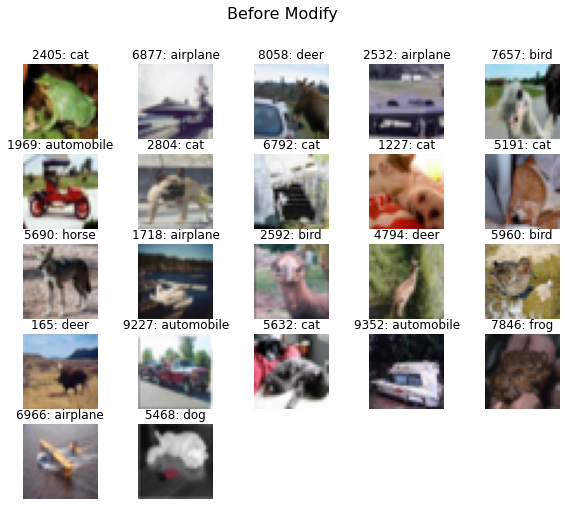

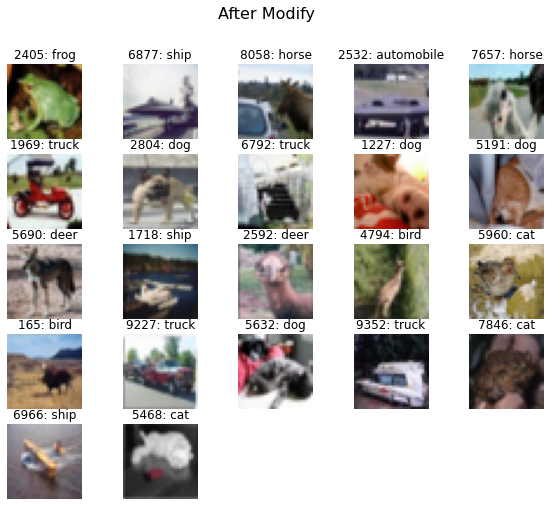

In [7]:
import matplotlib.pyplot as plt

# 이미지와 레이블을 입력받아서 시각화하는 함수 정의
# images: 이미지 데이터 리스트, labels: 레이블 데이터 리스트, title: 그래프 제목
def plot_images(images, labels, title):
    plt.figure(figsize=(10, 8))  # 그래프의 전체 크기 설정
    plt.suptitle(title, fontsize=16)  # 전체 그래프의 제목 설정
    
    for i, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(5, 5, i + 1)  # 5x5 격자 중 i+1 위치에 서브플롯 생성
        plt.imshow(img)  # 이미지 출력
        plt.title(f'{label_numbers[i]}: {label}')  # 서브플롯의 제목 설정
        plt.axis('off')  # 축 정보 표시 안 함

# 이미지 출력 - 수정 전
images_before = [x_test[i] for i in label_numbers]  # 테스트 데이터셋에서 특정 인덱스의 이미지 추출
plot_images(images_before, original_labels, 'Before Modify')  # 추출한 이미지와 원래 레이블로 시각화

# 이미지 출력 - 수정 후
images_after = [x_test[i] for i in label_numbers]  # 테스트 데이터셋에서 특정 인덱스의 이미지 추출
plot_images(images_after, modified_labels, 'After Modify')  # 추출한 이미지와 수정된 레이블로 시각화

In [8]:
# 데이터 프레임 생성
# 'Label', 'Before Modification', 'After Modification' 열을 가진 데이터 프레임을 생성합니다.
# 각 열에는 레이블 번호, 수정 전 레이블, 수정 후 레이블이 들어갑니다.
df_before_after = pd.DataFrame({
    'Label': label_numbers,
    'Before Modification': original_labels,
    'After Modification': modified_labels
})

df_before_after  # 생성된 데이터 프레임을 출력합니다.

,Label,Before Modification,After Modification
0,2405,cat,frog
1,6877,airplane,ship
2,8058,deer,horse
3,2532,airplane,automobile
4,7657,bird,horse
5,1969,automobile,truck
6,2804,cat,dog
7,6792,cat,truck
8,1227,cat,dog
9,5191,cat,dog


- 올바르게 모두 라벨 수정이 된 것으로 확인됩니다.
- 솔직히 몇몇 이미지는 오류라고 지정된 원래의 라벨이 더 맞는라벨 같지만, 일단은 제안된 사항대로 수정을 완료했습니다.
- 이제 모델링을 위한 전처리를 수행하겠습니다.

## 데이터 전처리

In [9]:
# 데이터셋의 픽셀 값을 0-255에서 0-1로 정규화합니다. 이는 모델의 학습을 더 잘 시키기 위함입니다.
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 클래스 레이블을 원-핫 인코딩으로 변환합니다. 이는 분류 문제에서 사용되는 일반적인 방법입니다.
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# 데이터의 차원과 레이블의 차원을 출력하여 확인합니다.
print("훈련 데이터 shape:", x_train.shape)
print("훈련 데이터 레이블 shape:", y_train.shape)
print("테스트 데이터 shape:", x_test.shape)
print("테스트 데이터 레이블 shape:", y_test.shape)

훈련 데이터 shape: (50000, 32, 32, 3)
훈련 데이터 레이블 shape: (50000, 10)
테스트 데이터 shape: (10000, 32, 32, 3)
테스트 데이터 레이블 shape: (10000, 10)


In [10]:
# 데이터를 훈련용과 검증용으로 분할합니다.
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2)
# 훈련 데이터의 차원을 출력합니다.
print("훈련 데이터 shape:", X_train.shape)
# 검증 데이터의 차원을 출력합니다.
print("검증 데이터 shape:", X_val.shape)

훈련 데이터 shape: (40000, 32, 32, 3)
검증 데이터 shape: (10000, 32, 32, 3)


# 2. 모델구축(feat. KerasTuner)

- KerasTuner는 Keras와 TensorFlow를 기반으로 하는 머신 러닝 모델을 효율적으로 조정하고 최적화하기 위한 도구입니다. 
- 이 도구를 사용하면 다양한 하이퍼파라미터 설정을 시도하여 최상의 모델을 찾을 수 있습니다. 
    - KerasTuner는 모델의 아키텍처와 하이퍼파라미터를 조정하는 과정을 자동화하여 모델 튜닝을 더 쉽게 만들어줍니다. 
    - 이를 통해 머신 러닝 모델을 빠르게 최적화하고 높은 성능을 달성할 수 있습니다.

## 하이퍼파라미터 튜닝 코드

- DeepTuner 클래스를 구축해서 모델의 하이퍼 파라미터 튜닝을 진행합니다

```python
class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X_train, y_train, validation_data, **fit_kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        model.fit(X_train, y_train, batch_size=trial.hyperparameters.Choice(
            'batch_size', [16, 32]), **fit_kwargs)

        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        return {name: value for name, value in zip(
            model.metrics_names,
            eval_scores)}
```

- 위 코드는 기본적으로 batch_size만을 하이퍼 파라미터 튜닝합니다.
- 해당 튜닝의 성능은 대체로 60%중후반 쯤입니다.
- 이번 프로젝트에서는 최대한 다양한 하이퍼 파라미터 튜닝을 시도하고자 합니다.
- 통상적으로 KerasTuner로 튜닝가능한 하이퍼 파라미터들에 대한 정보는 아래와 같습니다.
---

✔️ KerasTuner를 사용하여 조정할 수 있는 하이퍼파라미터 의 종류들

1. 필터 수 (Filters):
- CNN 레이어에서 사용되는 필터(커널)의 수
- 필터 수를 조정함으로써 모델의 복잡도와 학습 능력을 조절

2. 커널 크기 (Kernel Size):
- 각 컨볼루션 레이어에서 필터의 크기
- CNN의 경우 일반적으로 (3x3), (5x5) 등의 크기를 실험적으로 조정

3. 학습률 (Learning Rate):
- 모델 학습 시 사용되는 학습률
- 너무 높으면 학습이 불안정해질 수 있고, 너무 낮으면 학습이 느려질 수 있음

4. Dense 레이어의 유닛 수 (Units):
- Dense 레이어(완전 연결 레이어)에서의 뉴런(유닛)의 수
- 유닛 수를 조정하여 모델의 복잡도를 변경할 수 있음

5. 드롭아웃 비율 (Dropout Rate):
- 드롭아웃 레이어에서 사용되는 드롭아웃 비율
- 과적합을 방지하는 데 도움

6. 배치 크기 (Batch Size):
- 학습 시 각 배치에 포함되는 데이터 샘플의 수
- 배치 크기는 메모리 사용량과 학습 속도에 영향을 미칠 수 있음

7. 활성화 함수 (Activation Function):
- 레이어에서 사용되는 활성화 함수
- 예를 들어, relu, tanh, sigmoid 등을 선택할 수 있음

---

- 위와 같은 하이퍼 파라미터 튜닝을 할 수 있도록 DeepTuner와 모델 model_build코드를 수정했습니다.

In [11]:
class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X_train, y_train, validation_data, **fit_kwargs):
        hp = trial.hyperparameters  # 트라이얼의 하이퍼파라미터를 가져옵니다.

        # 모델을 빌드합니다. 하이퍼파라미터를 사용하여 모델을 구성합니다.
        model = self.hypermodel.build(hp)

        # 모델을 훈련합니다. 배치 사이즈는 하이퍼파라미터 선택을 통해 결정됩니다.
        model.fit(
            X_train, y_train, 
            batch_size=hp.Choice('batch_size', [16, 32]), 
            **fit_kwargs
        )

        # 검증 데이터를 사용하여 모델을 평가합니다.
        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        # 평가 결과를 딕셔너리 형태로 반환합니다. 모델의 메트릭 이름과 평가 점수를 매핑합니다.
        return {name: value for name, value in zip(model.metrics_names, eval_scores)}

- DeepTuner 클래스 정의
    - kt.Tuner 클래스를 상속하여 사용자 정의 튜너 클래스를 정의합니다.

- run_trial 메서드
    - 하이퍼파라미터 튜닝을 실행하는 메서드입니다.
    - trial은 하이퍼파라미터 튜닝 실험을 나타냅니다.
    - X_train, y_train: 모델의 훈련 데이터와 레이블입니다.
    - validation_data: 검증 데이터와 레이블을 포함하는 튜플입니다.
    - **fit_kwargs: 모델 훈련에 필요한 추가적인 매개변수를 받습니다.

- 하이퍼파라미터 설정
    - trial.hyperparameters를 사용하여 현재 실험에 사용되는 하이퍼파라미터를 설정합니다.

- 모델 빌드
    - self.hypermodel.build(hp)를 사용하여 하이퍼파라미터로 설정된 모델을 빌드합니다.

- 모델 훈련
    - model.fit을 사용하여 모델을 훈련합니다.
    - batch_size는 하이퍼파라미터로 설정되며, 선택지로 [16, 32]를 가집니다.

- 검증 데이터 평가
    - 검증 데이터를 사용하여 모델을 평가하고, 평가 결과를 eval_scores에 저장합니다.

- 결과 반환
    - 모델의 메트릭 이름과 해당 값들을 딕셔너리 형태로 반환합니다.

## 모델 Build 코드

- CIFAR-10의 다중 클래스 구현을 위해 간단한 CNN구조의 신경망 모델을 사용합니다.
- 모델구조는 아래와 같습니다.

![image](https://github.com/Kimgabe/AIFFEL_Online_Quest/assets/74717033/3ba4315d-3d4b-4ff9-a2cf-f05c35ab72b1)

- 위에서 언급한 바와 같이, 모델 하이퍼 파라미터(batch_size)외에 필터 수, 커널 크기, 학습률, Dense 레이어 유닛수, 드롭아웃 비율, 활성화 함수를 적용해 최적의 하이퍼 파라미터를 조정할 수 있도록 모델 구조를 설정했습니다.

In [12]:
def build_model(hp):
    model = tf.keras.Sequential()

    # 첫 번째 Conv2D 레이어
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),  # 필터 개수 조정
        kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),             # 커널 크기 선택
        activation=hp.Choice('activation_1', values=['relu', 'tanh']),     # 활성화 함수 선택
        input_shape=(32, 32, 3)                                            # 입력 이미지 크기 설정
    ))

    # 첫 번째 Pooling 레이어
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))             # 최대 풀링 레이어

    # 두 번째 Conv2D 레이어
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),  # 필터 개수 조정
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),             # 커널 크기 선택
        activation=hp.Choice('activation_2', values=['relu', 'tanh'])      # 활성화 함수 선택
    ))

    # 두 번째 Pooling 레이어
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))             # 최대 풀링 레이어

    # Flatten 레이어
    model.add(tf.keras.layers.Flatten())

    # Dense 레이어
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=512, step=64),  # 유닛 개수 조정
        activation=hp.Choice('dense_activation', values=['relu', 'tanh'])  # 활성화 함수 선택
    ))

    # Dropout 레이어
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))  # 드롭아웃 비율 조정

    # 출력 레이어
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    # 모델 컴파일
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),  # 학습률 추가
        loss='categorical_crossentropy',                                                # 손실 함수
        metrics=['accuracy']                                                            # 평가 메트릭
    )

    return model

# 3. 모델 학습

## 최적의 하이퍼 파라미터 탐색

In [13]:
# Keras Tuner를 사용하여 하이퍼파라미터 튜닝을 위한 DeepTuner 인스턴스 생성
my_keras_tuner = DeepTuner(
    # Bayesian 최적화 오라클을 사용하여 최적화할 목표와 시도할 최대 트라이얼 수, 랜덤 시드를 설정
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'),
        max_trials=10,
        seed=42),
    # 하이퍼모델 함수를 지정
    hypermodel=build_model,
    # 이전 프로젝트 결과를 덮어쓸지 여부를 결정
    overwrite=True,
    # 프로젝트 이름을 설정
    project_name='my_keras_tuner')

# 모델 학습 시간은 약 10분 정도 걸릴 것으로 예상됩니다!
# 하이퍼파라미터 튜닝을 위해 search 메소드를 호출하고, 훈련 데이터와 검증 데이터, 에포크 수를 지정
my_keras_tuner.search(
    X_train, Y_train, validation_data=(X_val, Y_val), epochs=10)

Trial 10 Complete [00h 01m 01s]
accuracy: 0.6759999990463257

Best accuracy So Far: 0.725600004196167
Total elapsed time: 00h 11m 53s


### 최적의 하이퍼 파라미터 및 모델 확인

- `my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]` 코드는 Keras Tuner를 사용하여 진행된 하이퍼파라미터 튜닝 중 최적의 결과를 가진 하이퍼파라미터 세트를 추출합니다. 여기서 `num_trials=10`은 상위 10개의 트라이얼 중에서 최적의 하이퍼파라미터를 선택하라는 의미입니다.
- 추출된 최적의 하이퍼파라미터 세트는 `best_hps` 변수에 저장됩니다.
- 이후 `for` 루프를 통해 `best_hps.values.items()`에서 각 하이퍼파라미터의 이름과 값을 순회하며 출력합니다. 이를 통해 어떤 하이퍼파라미터가 최적의 성능을 내는데 기여했는지 확인할 수 있습니다.

In [14]:
# 최적 하이퍼 파라미터 추출
best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]

# 최적 하이퍼파라미터를 출력합니다.
print("최적 하이퍼파라미터:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

최적 하이퍼파라미터:
filters_1: 96
kernel_size_1: 3
activation_1: relu
filters_2: 128
kernel_size_2: 5
activation_2: relu
dense_units: 320
dense_activation: relu
dropout: 0.2
learning_rate: 0.0003069273045576997
batch_size: 16


In [15]:
# 최적 하이퍼 파라미터를 적용한 모델 생성
model = build_model(best_hps)
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 30, 30, 96)        2688      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 15, 15, 96)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 11, 11, 128)       307328    
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 3200)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 320)               1024320   
_________________________________________________________________
dropout_11 (Dropout)         (None, 320)             

## 최적 하이퍼 파라미터로 모델 학습 수행

In [16]:
# 모델을 학습시키는 코드입니다.
# X_train과 Y_train을 사용하여 모델을 학습시키고, 이 과정에서
# X_val과 Y_val을 사용하여 검증 데이터에 대한 성능을 평가합니다.
history = model.fit(X_train, Y_train, 
                   epochs=50, # 모델을 학습시킬 때 전체 데이터셋에 대해 50번 반복 학습
                    validation_data=(X_val, Y_val)) # 검증 데이터셋을 사용하여 학습 과정에서의 성능을 평가합니다.

Epoch 1/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.5642 - accuracy: 0.4305 - val_loss: 1.2923 - val_accuracy: 0.5388
Epoch 2/50
1250/1250 [==============================] - 6s 4ms/step - loss: 1.2155 - accuracy: 0.5714 - val_loss: 1.1573 - val_accuracy: 0.5919
Epoch 3/50
1250/1250 [==============================] - 6s 4ms/step - loss: 1.0595 - accuracy: 0.6279 - val_loss: 1.0072 - val_accuracy: 0.6455
Epoch 4/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9567 - accuracy: 0.6655 - val_loss: 0.9688 - val_accuracy: 0.6624
Epoch 5/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.8747 - accuracy: 0.6969 - val_loss: 0.9453 - val_accuracy: 0.6759
Epoch 6/50
1250/1250 [==============================] - 6s 4ms/step - loss: 0.8014 - accuracy: 0.7216 - val_loss: 0.9249 - val_accuracy: 0.6824
Epoch 7/50
1250/1250 [==============================] - 6s 4ms/step - loss: 0.7339 - accuracy: 0.7460 - val_loss: 0.8703 - val_accuracy:

# 4. 모델 성능 평가

## 학습 결과 시각화

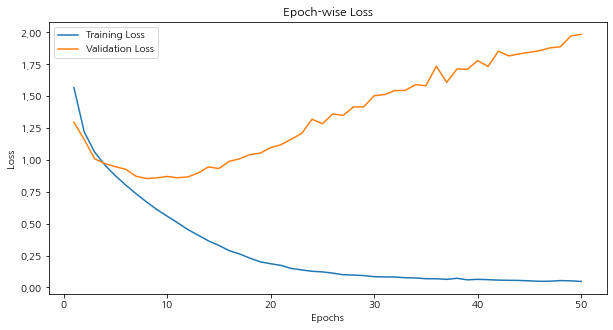

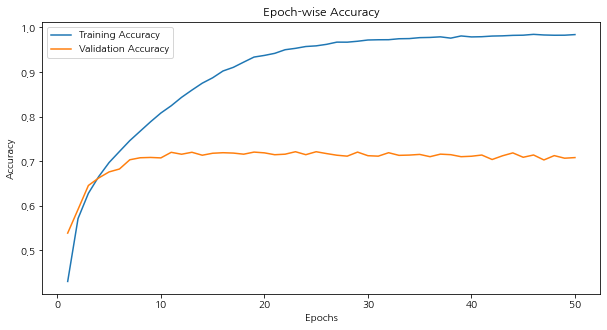

In [17]:
import koreanize_matplotlib
import seaborn as sns

# 학습 히스토리에서 손실과 정확도 추출
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 에포크 별 손실 그래프
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, len(train_loss) + 1), y=train_loss, label='Training Loss')
sns.lineplot(x=range(1, len(val_loss) + 1), y=val_loss, label='Validation Loss')
plt.title('Epoch-wise Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 에포크 별 정확도 그래프
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, len(train_acc) + 1), y=train_acc, label='Training Accuracy')
sns.lineplot(x=range(1, len(val_acc) + 1), y=val_acc, label='Validation Accuracy')
plt.title('Epoch-wise Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 모델 예측 결과 확인

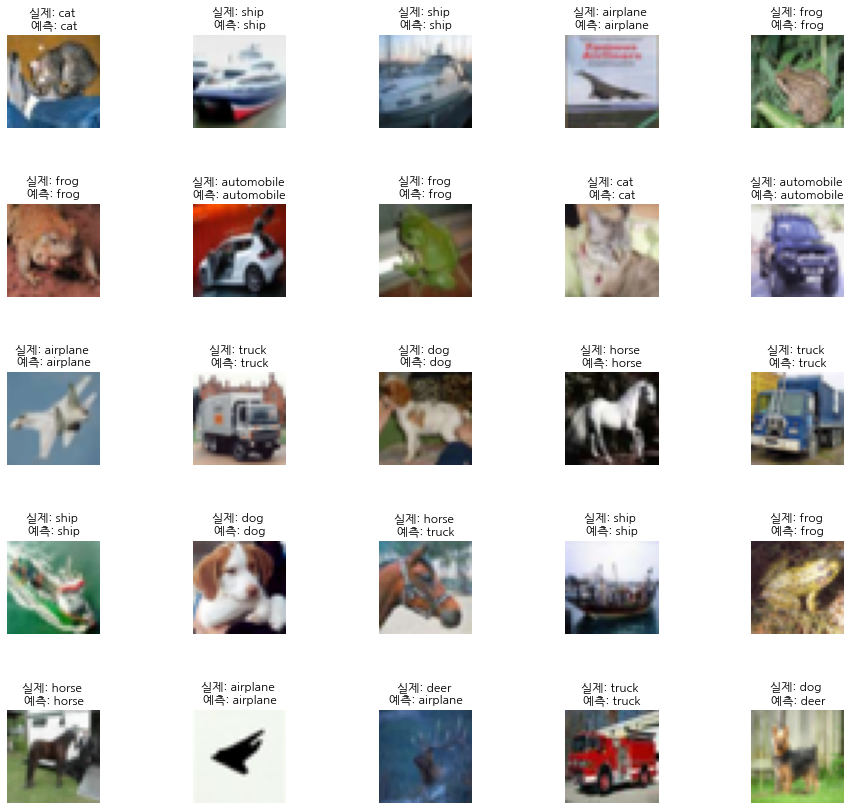

In [18]:
import numpy as np

# 모델을 사용하여 x_test 데이터에 대한 예측 확률을 얻습니다.
predicted_probabilities = model.predict(x_test)
# 예측 확률에서 가장 높은 확률을 가진 클래스의 인덱스를 얻어 예측된 클래스로 지정합니다.
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# 5x5 격자의 서브플롯을 생성하여 결과를 시각화합니다. 각 서브플롯은 하나의 테스트 이미지를 나타냅니다.
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.ravel()

# 첫 25개의 테스트 이미지에 대해 반복합니다.
for i in range(25):
    axes[i].imshow(x_test[i]) # i번째 테스트 이미지를 서브플롯에 표시합니다.
    true_label = class_names[np.argmax(y_test[i])]  # 실제 레이블을 얻습니다.
    pred_label = class_names[predicted_classes[i]] # 예측된 레이블을 얻습니다.
    axes[i].set_title("실제: %s \n예측: %s" % (true_label, pred_label)) # 서브플롯의 제목을 실제 레이블과 예측 레이블로 설정합니다.
    axes[i].axis('off') # 서브플롯의 축을 표시하지 않습니다.

plt.subplots_adjust(wspace=1) # 서브플롯 간의 간격을 조정합니다.
plt.show() # 시각화된 그래프를 표시합니다.

In [21]:
# 모델을 사용하여 x_test 데이터에 대한 예측 확률을 얻습니다.
predicted_probabilities = model.predict(x_test)
# 예측 확률에서 가장 높은 확률을 가진 클래스의 인덱스를 얻어 예측된 클래스로 지정합니다.
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# 전체 데이터셋에 대한 정확도 계산
correct_predictions = np.equal(predicted_classes, np.argmax(y_test, axis=1))
accuracy = np.mean(correct_predictions)

print(f"전체 데이터셋에 대한 예측 정확도: {accuracy * 100:.2f}%")

전체 데이터셋에 대한 예측 정확도: 70.66%


## 모델 저장

In [19]:
# 환경 변수 'HOME'에서 사용자의 홈 디렉토리 경로를 가져온 후, 지정된 경로에 이어붙임
save_path = os.getenv('HOME') + '/aiffel/mlops/best_model/1'
# 'save_path'에 'model'이라는 파일명을 이어붙여 전체 파일 경로를 생성
fname = os.path.join(save_path, 'model')
# 'model' 객체를 'fname' 경로에 저장
model.save(fname)

INFO:tensorflow:Assets written to: /aiffel/aiffel/mlops/best_model/1/model/assets


In [20]:
# shutil 모듈을 가져옵니다.
import shutil

# 압축할 폴더의 경로를 지정합니다.
folder_to_compress = "/aiffel/aiffel/mlops/best_model/1/"

# 생성될 압축 파일의 이름을 지정합니다.
zip_filename = "model.zip"

# shutil.make_archive 함수를 사용하여 폴더를 '.zip' 형식으로 압축합니다.
# 첫 번째 인자는 압축 파일의 이름에서 확장자를 제외한 부분,
# 두 번째 인자는 압축 파일의 형식,
# 세 번째 인자는 압축할 폴더의 경로입니다.
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', folder_to_compress)

# 압축 파일을 다운로드할 수 있는 링크를 생성하기 위해 IPython.display 모듈에서 FileLink를 가져옵니다.
from IPython.display import FileLink
# FileLink 함수를 사용하여 생성된 압축 파일에 대한 다운로드 링크를 생성합니다.
FileLink(zip_filename)

/aiffel/aiffel/mlops/model.zip

---

# 🧐 회고

## KEEP
- 머신러닝베이스와는 다른 형태로 딥러닝의 MLOps를 수행할 수 있는 과정을 학습하고 개괄적인 내용을 이해했다.
- 이해한 내용을 바탕으로 1 Cycle로 코드를 구현해보았다.
- 학습에서 사용한 하이퍼 파라미터(batch_size)외에 필터 수, 커널 크기, 학습률, Dense 레이어 유닛수, 드롭아웃 비율, 활성화 함수를 적용해 최적의 하이퍼 파라미터를 찾도록 build_model 함수를 작성해보았다.


## PROBLEM
- 주말에 여유가 좀 있었는데, 거의 손대지 않고 하루에 다하려고 하니 시간에 많이 쫒겼던 것 같다.
- 전반적인 작동 과정 및 흐름에 대한 이해는 했지만, 개별 코드 마다 정확하게 어떤 이유로, 왜 해야 하는지에 대한 이해가 좀 부족한 것 같다.
- 특히 모델 배포 부분은 나중 AIFFEL톤을 위해서라도 숙달이 필요하다.
- GPU성능은 LMS가 월등히 좋아서 여기서 만든 모델파일을 로컬로 옮겨서 배포하는 방법에 대한 이해 및 구현이 필요하다.


## TRY
- 코드를 다시 검토하면서 하나 하나의미를 찾아서 노트정리 하기
- 노드에서 제안해준 [박찬성님의 프로젝트 : semantic-segmentation-ml-pipeline](https://github.com/deep-diver/semantic-segmentation-ml-pipeline) 분석하면서 TFX의 세부 컴포넌트를 더 이해하고, 블로그 포스팅 작성하기
---
---